PARAMETER SUMMARY
Species A (HQNO):
  D = 40.0 µm²/s (range: 36.0–44.0)
  S = 23.97 ng/(mL·s) (range: 23.23–24.71)
  C = 0.52836 s⁻¹ (range: 0.19736–0.85936)
  Mean concentration: 125.90 ng/mL

Species B (RHL):
  D = 15.0 µm²/s (range: 10.0–20.0)
  S = 4.60031 µg/(mL·s) (range: 3.10199–6.09863)
  C = 0.11585 s⁻¹ (range: 0.04556–0.04556)
  Mean concentration: 69.5919 µg/mL


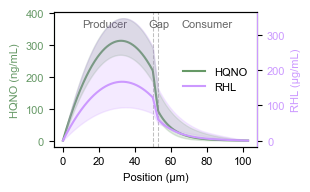

In [31]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from itertools import product

# PNAS figure style
final_width_cm = 8    # width in cm
final_height_cm = 5   # height in cm
final_width_in = final_width_cm / 2.54
final_height_in = final_height_cm / 2.54
pnas_fontsize = 8  # points
plt.rcParams.update({
    'font.size': pnas_fontsize,
    'font.family': 'Arial',
    'axes.labelsize': pnas_fontsize,
    'axes.titlesize': pnas_fontsize,
    'xtick.labelsize': pnas_fontsize,
    'ytick.labelsize': pnas_fontsize,
    'legend.fontsize': pnas_fontsize,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# --- Geometry (shared) ---
L_val = 50.0                # µm Length of producer & consumer regions (each)
d_val = 3.0                 # µm Length of diffusive gap
W_val = 50.0                # µm Width of producer/consumer chambers
W_gap_val = 0.5/2*W_val     # µm Width of the diffusive gap (== 0.25 * W_val)

# === HQNO (Species A) - CONVERTED TO ng/mL ===
D_A_rng = (36.0, 40.0, 44.0)                    # µm²/s diffusion
S_A_rng = (23.23, 23.97, 24.71)                 # s⁻¹ production
C_A_rng = (0.19736, 0.52836, 0.85936)           # s⁻¹ consumption

# === RHL (Species B) - PLACEHOLDER VALUES ===
D_B_rng = (10, 15.00, 20)                                   # µm²/s 
S_B_rng = (3.10199, 4.60031, 6.09863)                       # s⁻¹ 
C_B_rng = (0.04556, 0.11585, 0.04556)                       # s⁻¹ 

# --- Symbolic setup (solve once) ---
L, d, D, S, C, W, W_gap, x = sp.symbols('L d D S C W W_gap x', positive=True)
k = sp.sqrt(C / D)

A_sym, C1_sym, C2_sym, M_sym = sp.symbols('A C1 C2 M')

# Piecewise solution forms:
R_I   = -S/(2*D)*x**2 + A_sym*x                         # Producer with source S
R_II  = C1_sym*x + C2_sym                               # Gap (pure diffusion)
R_III = M_sym*sp.sinh(k*(2*L + d - x))                  # Consumer with sink C

# Derivatives
R_Ip, R_IIp, R_IIIp = sp.diff(R_I, x), sp.diff(R_II, x), sp.diff(R_III, x)

# BCs + width-weighted flux continuity
eqs = [
    sp.Eq(R_I.subs(x, 0), 0),                                # R(0) = 0
    sp.Eq(R_III.subs(x, 2*L + d), 0),                        # R(2L+d) = 0
    sp.Eq(R_I.subs(x, L), R_II.subs(x, L)),                  # Continuity at x=L
    sp.Eq(W * R_Ip.subs(x, L), W_gap * R_IIp.subs(x, L)),    # Flux continuity at x=L
    sp.Eq(R_II.subs(x, L + d), R_III.subs(x, L + d)),        # Continuity at x=L+d
    sp.Eq(W_gap * R_IIp.subs(x, L + d), W * R_IIIp.subs(x, L + d)) # Flux continuity at x=L+d
]

solution_expr = sp.solve(eqs, (A_sym, C1_sym, C2_sym, M_sym), dict=True)[0]

def conc_curve(D_val, S_val, C_val, x_vals):
    """Vectorized steady-state concentration R(x) for given D,S,C."""
    num = {L: L_val, d: d_val, W: W_val, W_gap: W_gap_val, D: D_val, S: S_val, C: C_val}
    A_val  = float(solution_expr[A_sym].subs(num))
    C1_val = float(solution_expr[C1_sym].subs(num))
    C2_val = float(solution_expr[C2_sym].subs(num))
    M_val  = float(solution_expr[M_sym].subs(num))
    k_val  = float(sp.sqrt(C_val / D_val))

    x_arr = np.asarray(x_vals, dtype=float)
    out = np.empty_like(x_arr)

    m1 = x_arr < L_val
    m2 = (x_arr >= L_val) & (x_arr < L_val + d_val)
    m3 = ~(m1 | m2)

    out[m1] = -S_val/(2 * D_val) * x_arr[m1]**2 + A_val * x_arr[m1]
    out[m2] = C1_val * x_arr[m2] + C2_val
    out[m3] = M_val * np.sinh(k_val * (2 * L_val + d_val - x_arr[m3]))
    return out

def envelope_for_ranges(D_rng, S_rng, C_rng, x_vals):
    """Mean curve = mid parameters. Envelope = pointwise min/max over corners."""
    D_lo, D_mid, D_hi = D_rng
    S_lo, S_mid, S_hi = S_rng
    C_lo, C_mid, C_hi = C_rng

    R_mean = conc_curve(D_mid, S_mid, C_mid, x_vals)

    corners = list(product([D_lo, D_hi], [S_lo, S_hi], [C_lo, C_hi]))
    R_min = np.full_like(x_vals, np.inf, dtype=float)
    R_max = np.full_like(x_vals, -np.inf, dtype=float)
    for (Dv, Sv, Cv) in corners:
        R = conc_curve(Dv, Sv, Cv, x_vals)
        R_min = np.minimum(R_min, R)
        R_max = np.maximum(R_max, R)
    return R_mean, R_min, R_max

# Build curves
x_vals = np.linspace(0, 2*L_val + d_val, 600)
R_A_mean, R_A_min, R_A_max = envelope_for_ranges(D_A_rng, S_A_rng, C_A_rng, x_vals)
R_B_mean, R_B_min, R_B_max = envelope_for_ranges(D_B_rng, S_B_rng, C_B_rng, x_vals)

# Print statistics
print("="*70)
print("PARAMETER SUMMARY")
print("="*70)
print(f"Species A (HQNO):")
print(f"  D = {D_A_rng[1]:.1f} µm²/s (range: {D_A_rng[0]:.1f}–{D_A_rng[2]:.1f})")
print(f"  S = {S_A_rng[1]:.2f} ng/(mL·s) (range: {S_A_rng[0]:.2f}–{S_A_rng[2]:.2f})")
print(f"  C = {C_A_rng[1]:.5f} s⁻¹ (range: {C_A_rng[0]:.5f}–{C_A_rng[2]:.5f})")
print(f"  Mean concentration: {R_A_mean.mean():.2f} ng/mL")
print()
print(f"Species B (RHL):")
print(f"  D = {D_B_rng[1]:.1f} µm²/s (range: {D_B_rng[0]:.1f}–{D_B_rng[2]:.1f})")
print(f"  S = {S_B_rng[1]:.5f} µg/(mL·s) (range: {S_B_rng[0]:.5f}–{S_B_rng[2]:.5f})")
print(f"  C = {C_B_rng[1]:.5f} s⁻¹ (range: {C_B_rng[0]:.5f}–{C_B_rng[2]:.5f})")
print(f"  Mean concentration: {R_B_mean.mean():.4f} µg/mL")
print("="*70)

# --- DUAL Y-AXIS PLOT with PNAS style ---
fig, ax1 = plt.subplots(figsize=(final_width_in, final_height_in))

# Species A (HQNO) on left y-axis - color #669966
color_A = '#669966'
ax1.set_xlabel("Position (µm)", fontsize=pnas_fontsize)
ax1.set_ylabel("HQNO (ng/mL)", color=color_A, fontsize=pnas_fontsize)
lineA, = ax1.plot(x_vals, R_A_mean, color=color_A, label="HQNO", linewidth=1.5)
ax1.fill_between(
    x_vals, R_A_min, R_A_max,
    alpha=0.2, color=color_A
)
ax1.tick_params(axis='y', labelcolor=color_A, labelsize=pnas_fontsize)
ax1.tick_params(axis='x', labelsize=pnas_fontsize)
ax1.spines['left'].set_color(color_A)

# Species B (RHL) on right y-axis - color #cc99ff
ax2 = ax1.twinx()
color_B = '#cc99ff'
ax2.set_ylabel("RHL (µg/mL)", color=color_B, fontsize=pnas_fontsize)
lineB, = ax2.plot(x_vals, R_B_mean, color=color_B, label="RHL", linewidth=1.5)
ax2.fill_between(
    x_vals, R_B_min, R_B_max,
    alpha=0.2, color=color_B
)
ax2.tick_params(axis='y', labelcolor=color_B, labelsize=pnas_fontsize)
ax2.spines['right'].set_color(color_B)

# Region markers
ax1.axvline(x=L_val, linestyle='--', color='gray', linewidth=0.75, alpha=0.5)
ax1.axvline(x=L_val + d_val, linestyle='--', color='gray', linewidth=0.75, alpha=0.5)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', 
          frameon=False, fontsize=pnas_fontsize)

#ax1.grid(True, alpha=0.2, linewidth=0.5)

# Add region labels using axis coordinates (0-1 range) instead of data coordinates
ax1.text(0.25, 0.95, 'Producer', transform=ax1.transAxes,
         ha='center', va='top', fontsize=pnas_fontsize, alpha=0.6)
ax1.text(0.515, 0.95, 'Gap', transform=ax1.transAxes,
         ha='center', va='top', fontsize=pnas_fontsize, alpha=0.6)
ax1.text(0.755, 0.95, 'Consumer', transform=ax1.transAxes,
         ha='center', va='top', fontsize=pnas_fontsize, alpha=0.6)

plt.tight_layout()
plt.savefig("/Volumes/ScientificData/Users/Giulia(botgiu00)/Papers/bottacin2025/Analysis/Figures/Figure3Version2/V2_3C_model_prediction/V2_3C_hqno_rhl_concentrations_parameter_range.pdf", transparent=True, dpi=300)
plt.show()
